In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Conv2DTranspose
import matplotlib.pyplot as plt
import pickle

In [ ]:
#generator model

def generator_build(gen_input,image_size) :
    
    image_resize = image_size//4
    layer_filters = [128,64,32,1]
    kernel_size = 5
    x = Dense(image_resize*image_resize*layer_filters[0])(gen_input)
    x = tf.keras.layers.Reshape((image_resize,image_resize,layer_filters[0]))(x)
    for filters in layer_filters :
        if filters > layer_filters[-2]:
            strides=2
        else :
            strides=1
        x = BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    generator_model = tf.keras.Model(inputs = gen_input,outputs=x,name='generator_model')
    return generator_model

In [ ]:
#discriminator model

def discriminator_build(dis_input) :
    kernel_size= 5
    layer_filters = [32,64,128,256]
    x = dis_input
    for filters in layer_filters : 
        if filters == layer_filters[-1] :
            strides = 1
        else :
            strides = 2
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = Dense(1,activation='sigmoid')(x)
    
    discriminator = tf.keras.Model(inputs=dis_input,outputs=x,name='discriminator_model')
    
    return discriminator

In [ ]:
def build_and_train_models():
    (x_train,_),(_,_) = tf.keras.datasets.mnist.load_data()
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train,[-1,image_size,image_size,1]).astype('float')/255
    
    
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size,image_size,1)
    
#    build discrimator model

    discriminator = discriminator_build(tf.keras.layers.Input(shape = input_shape))
    optimizer = tf.keras.optimizers.RMSprop(lr=lr,decay=decay)
    discriminator.compile(loss ='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    #discriminator.summary()
    
#    build generator model
    inputs = tf.keras.layers.Input(shape = (latent_size,))
    generator = generator_build(inputs,image_size)
    #generator.summary()

#    build adversial model
    
    optimizer = tf.keras.optimizers.RMSprop(lr=lr*0.5,decay=decay*0.5)
    
    discriminator.trainable = False
    
    adversial = tf.keras.Model(inputs,discriminator(generator(inputs)),name = 'dcgan_model')
    
    adversial.compile(loss='binary_crossentropy',optimizer= optimizer,metrics=['accuracy'])
    #adversial.summary()
    
    
#    train all models
    models = (generator,discriminator,adversial)
    params = (batch_size,latent_size,train_steps)
    train(models,x_train,params)
    return models

In [ ]:
def train(models,x_train,params) :
    generator,discriminator,adversial = models
    batch_size,latent_size,train_steps = params
    train_size = x_train.shape[0]
    save_interval = 500
    #noise_input = np.random.uniform(-1.0,1.0,size=[])
    for i in range(train_steps) :
        rand_indexes = np.random.randint(0,train_size,size=batch_size)
        real_images = x_train[rand_indexes]
        
        noise = np.random.uniform(-1.0,1.0,size=[batch_size,latent_size])
        fake_images = generator.predict(noise)
        x = np.concatenate((real_images,fake_images))
        y = np.ones((2*batch_size,1))
        y[batch_size:,:] = 0.0
        
        loss,acc = discriminator.train_on_batch(x,y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        #print(log)
        noise = np.random.uniform(-1.0,1.0,size=[batch_size,latent_size])
        y = np.ones((batch_size,1))
        loss,acc = adversial.train_on_batch(noise,y)
        log = "%s: [adversial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)

In [ ]:
models = build_and_train_models()

In [ ]:
generator,discriminator,adversial = models

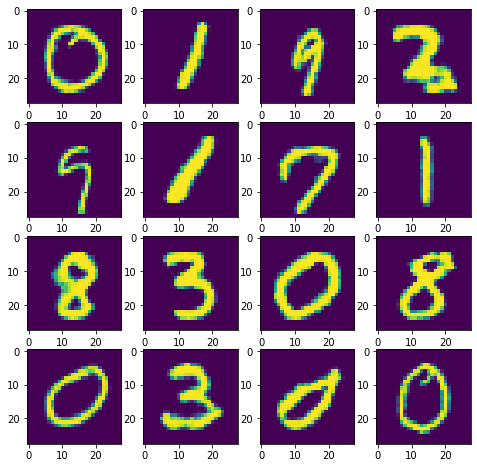

In [ ]:
noise = np.random.uniform(-1.0,1.0,size=[16,100])
fake_image = generator.predict(noise)
fig = plt.figure(figsize=(8,8))
w = 28
h = 28
columns=4
rows = 4
for i in range(1,columns*rows+1) :
  img = fake_image[i-1].reshape(28,28)
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
plt.show()

In [ ]:
model_json = generator.to_json()
with open("dcgan.json", "w") as json_file:
    json_file.write(model_json)
generator.save_weights("dcgan.h5")